# Анализ седельных тягачей КАМАЗ 5490 (2015-2022)

# Краткое описание предметной области и исходных данных
<font size = 3><div style="text-align: justify">В качестве анализируемой информации выступают данные о ценах предложения на рынке транспортных средств (КАМАЗ 2015-2022 годов выпуска) в городах России. В процессе анализа на 1 этапе был произведен автоматизированный сбор данных о ценах предложения (основные характеристики: год выпуска 2015-2022, седельный тягач, имеется регистрация в РФ, кроме битых). К основным ценообразующим факторам относятся: год выпуска (хронологический возраст), пробег, мощность двигателя (л.с./кВт), объем двигателя, тип коробки передач (АТ/МТ), состояние, класс, колесная пара и тип топлива. Факторы, которые не были учтены в силу невозможности их объективного установления: дубликат ПТС, наличие серьезных аварий и ремонтов, наличие долгов по штрафам. Имеется потребность в анализе рынка транспортных средств и ценообразования на нем с целью построения оценочных математических моделей, предсказывающих стоимость транспортных средств в зависимости от основных ценообразующих факторов.</div></font>


# Формулировка цели и постановка задач
<font size = 3><div style="text-align: justify">**Цель:**реализация парсинга для сбора необходимой информации для создания качественной математической модели оценки стоимости транспортных средств (КАМАЗ 2015-2022 годов выпуска) в зависимости от основных ценообразующих факторов.</div></font>

<font size = 3>**Задачи:**
1. Сбор данных с использованием парсинга.
2. Формирование датасета.
3. Анализ данных на наличие выбросов (boxplot).
4. Анализ данных на соответствие нормальному закону распределения (построение гистограммы).
5. Вывод основных показателей (описательная статистика).
6. Анализ данных на наличие существенных отклонений между признаками.
7. Поиск и анализ взаимосвязей между ценой и ценообразующими факторами.
8. Отбор ценообразующих факторов.
9. Постороение различных моделей (обучение) для решения задач регрессии.
10. Проверка качества моделей (тестирование).
11. Выбор лучшей модели оценки стоимости.
12. Кросс-валидация полученной модели и улучшение полученной модели.
13. Построение прогноза для объекта оценки.
14. Выводы.</font>

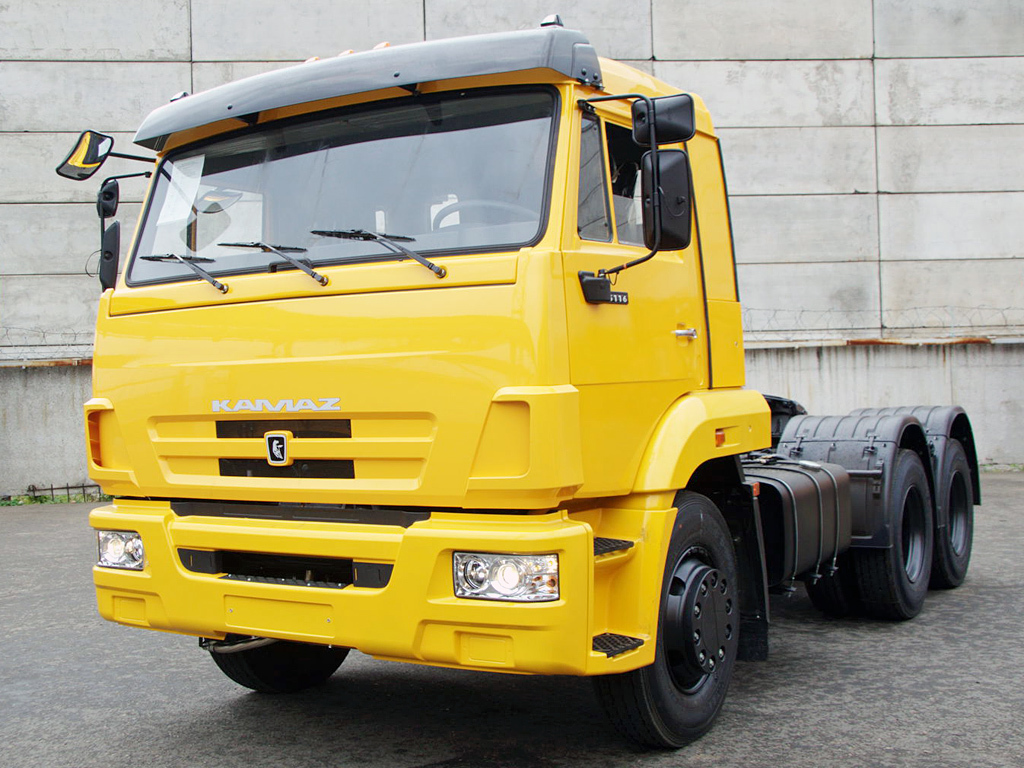

<font size = 4><div style="text-align: justify">**1. Реализация парсинга:**</div></font>

In [1]:
#Импортируем необходиимых библиотек для реализации парсинга
from selenium import webdriver
from selenium_stealth import stealth # делает похожим на настоящего пользователя
from time import sleep
from tqdm import tqdm
import pandas as pd
import numpy as np

In [52]:
options = webdriver.ChromeOptions()
options.add_argument("start_maximized")

options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option('useAutomationExtension', False)
driver = webdriver.Chrome(options=options, executable_path=r"C:\Python\chromedriver.exe")

stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )

infs_all = []
year_price_all = []
price_all = []
link_all = []
owners_all = []
obs_all = []
city_all = []

p = 25 # количество страниц
page = 1

for page in tqdm(range(p), 'Обработанно страниц'):
    
    url = f"https://www.avito.ru/rossiya/gruzoviki_i_spetstehnika/tyagachi/kamaz-ASgBAgICAkRU5E3exA3Ynzo?cd=1&f=ASgBAgECAkRU5E3exA3YnzoBRdDhDRd7ImZyb20iOjIwMTUsInRvIjoyMDIyfQ&p={page}"
    driver.get(url)
    
    #sleep(2)
    
    # объем, мощность, колесная пара, топливо, класс ЕВРО
    blocks = driver.find_elements_by_class_name('iva-item-autoParamsStep-WzfS8')
    for block in blocks:
        infs = block.find_element_by_tag_name('div').text
        infs_all.append(infs)
        #print(infs)
    
    # модель, год, ссылка
    blocks = driver.find_elements_by_class_name('iva-item-titleStep-pdebR')
    for block in blocks:
        year_price = block.find_element_by_tag_name('a').get_attribute("title")
        # ссылка
        link = block.find_element_by_tag_name('a').get_attribute("href")
        year_price_all.append(year_price)
        link_all.append(link)
        #print(year_price)
    
    # стоимость
    blocks = driver.find_elements_by_class_name('price-price-JP7qe')
    for block in blocks:
        price = block.find_element_by_tag_name('span').text
        price_all.append(price)
    
    # текст объявления
    blocks = driver.find_elements_by_class_name('iva-item-descriptionStep-C0ty1')
    for block in blocks:
        obs = block.find_element_by_tag_name('div').text
        obs_all.append(obs)
        #print(infs)

    #print('Обработанно страниц', page)
        
# количество владельцев (необходимо писать обработку ошибок)
for lnk in tqdm(link_all, 'Сбор данных'):
    try:
        sleep(3)
        driver.get(lnk) # открываем предложение о продаже
        owners = driver.find_element_by_class_name('params-paramsList-2PiKQ').text
        owners_all.append(owners)
        #print(owners)
        #print('Обработанно объявлений', lnk)
        
        sleep(1)
        # местоположение
        city = driver.find_element_by_class_name('style-item-address-1E4lt').find_element_by_tag_name('span').text
        city_all.append(city)
    except:
        owners = 9999
        city = 9999
        owners_all.append(owners)
        city_all.append(city)
        continue

C:\Users\skapr\AppData\Local\Temp\ipykernel_23264\252913108.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(options=options, executable_path=r"C:\Python\chromedriver.exe")
Обработанно страниц:   0%|                                                                      | 0/25 [00:00<?, ?it/s]C:\Users\skapr\AppData\Local\Temp\ipykernel_23264\252913108.py:35: DeprecationWarning: find_elements_by_class_name is deprecated. Please use find_elements(by=By.CLASS_NAME, value=name) instead
  blocks = driver.find_elements_by_class_name('iva-item-autoParamsStep-WzfS8')
C:\Users\skapr\AppData\Local\Temp\ipykernel_23264\252913108.py:37: DeprecationWarning: find_element_by_tag_name is deprecated. Please use find_element(by=By.TAG_NAME, value=name) instead
  infs = block.find_element_by_tag_name('div').text
C:\Users\skapr\AppData\Local\Temp\ipykernel_23264\252913108.py:42: DeprecationWarning: find_elements_by_class_name is depre

In [54]:
arr_infs_all = np.array(infs_all)

infs_pd = []
for a in range(len(arr_infs_all)):
    f = arr_infs_all[a].split(',') #делим текст на части
    infs_pd.append(f)

print('Количество обработанных объявлений:', len(infs_pd))
print('Информация имеет вид:')
infs_pd[0]

Количество обработанных объявлений: 1375
Информация имеет вид:


['12.0 л', ' 450 л.с.', ' 4×2', ' дизель', ' Евро 5']

In [57]:
# Преобразуем информацию в DataFrame
df_infs = pd.DataFrame(infs_pd)
df_infs

,0,1,2,3,4
0,12.0 л,450 л.с.,4×2,дизель,Евро 5
1,12.0 л,401 л.с.,4×2,дизель,None
2,12.0 л,401 л.с.,4×2,дизель,Евро 5
3,0.7 л,300 л.с.,6×6,дизель,Евро 5
4,11.8 л,300 л.с.,6×6,дизель,None
...,...,...,...,...,...
1370,11.8 л,400 л.с.,6×6,дизель,Евро 5
1371,11.8 л,400 л.с.,6×6,дизель,Евро 5
1372,300 л.с.,6×4,дизель,Евро 5,None
1373,12.0 л,428 л.с.,6×4,дизель,None


In [77]:
# сохраняем в Excel
writer = pd.ExcelWriter('infs.xlsx')
df_infs.to_excel(writer, 'marks')
writer.save()

In [59]:
arr_year_price_all = np.array(year_price_all)

year_price_all_pd = []
for a in range(len(arr_year_price_all)):
    f = arr_year_price_all[a].split(',') #делим текст на части
    year_price_all_pd.append(f)

print('Количество обработанных объявлений:', len(year_price_all_pd))
print('Информация имеет вид:')
year_price_all_pd[0]

Количество обработанных объявлений: 1375
Информация имеет вид:


['КамАЗ 5490', ' 2022 в Санкт-Петербурге']

In [60]:
# Преобразуем информацию в DataFrame
df_year_price = pd.DataFrame(year_price_all_pd)
df_year_price

,0,1
0,КамАЗ 5490,2022 в Санкт-Петербурге
1,КамАЗ 5490 NEO 2,2020 в Балашихе
2,КамАЗ 5490-023-87(S5) NEO,2020 в Оренбурге
3,КамАЗ 53504,2018 в Сургуте
4,КамАЗ 53504,2015 в Бузулуке
...,...,...
1392,КамАЗ 65225,2022 в Москве
1393,КамАЗ 65225,2022 в Москве
1394,КамАЗ 65116-48(A5),2022 в Москве
1395,КамАЗ 65206,2022 в Набережных Челнах


In [62]:
df_price = pd.DataFrame(price_all)
df_price

,0
0,1 300 000 ₽
1,6 800 000 ₽ c НДС
2,4 900 000 ₽ c НДС
3,4 300 000 ₽
4,934 920 ₽
...,...
1392,10 250 000 ₽
1393,10 250 000 ₽
1394,5 700 000 ₽
1395,10 900 001 ₽ c НДС


In [67]:
df_link = pd.DataFrame(link_all)
df_link

,0
0,https://www.avito.ru/sankt-peterburg/gruzoviki...
1,https://www.avito.ru/balashiha/gruzoviki_i_spe...
2,https://www.avito.ru/orenburg/gruzoviki_i_spet...
3,https://www.avito.ru/surgut/gruzoviki_i_spetst...
4,https://www.avito.ru/buzuluk/gruzoviki_i_spets...
...,...
1392,https://www.avito.ru/moskva/gruzoviki_i_spetst...
1393,https://www.avito.ru/moskva/gruzoviki_i_spetst...
1394,https://www.avito.ru/moskva/gruzoviki_i_spetst...
1395,https://www.avito.ru/naberezhnye_chelny/gruzov...


In [84]:
arr_owners_all = np.array(owners_all)

arr_owners_all_pd = []
for a in range(len(arr_owners_all)):
    f = arr_owners_all[a].split(':') #делим текст на части
    arr_owners_all_pd.append(f)

print('Количество обработанных объявлений:', len(arr_owners_all_pd))
print('Информация имеет вид:')
arr_owners_all_pd[0]

Количество обработанных объявлений: 1424
Информация имеет вид:


['Марка',
 ' КамАЗ\nСерия',
 ' 5490\nМодель',
 ' 5490\nТип',
 ' Седельный\nГод выпуска',
 ' 2022\nКолёсная формула',
 ' 4×2\nМощность',
 ' 450 л.с.\nЭкологический класс',
 ' Евро 5\nКоробка передач',
 ' Автомат\nТип двигателя',
 ' Дизель\nОбъём двигателя',
 ' 12 л\nТип кабины',
 ' 2-х местная с 1 спальным\nПодвеска кабины',
 ' Пневматическая\nВысота седельного устройства',
 ' 1250 мм\nСостояние',
 ' Новое\nПТС или ПСМ',
 ' Оригинал\nVIN, номер кузова или SN',
 ' XTC5*************\nДоступность',
 ' В наличии']

In [86]:
df_owners = pd.DataFrame(arr_owners_all_pd)
df_owners

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,Марка,КамАЗ\nСерия,5490\nМодель,5490\nТип,Седельный\nГод выпуска,2022\nКолёсная формула,4×2\nМощность,450 л.с.\nЭкологический класс,Евро 5\nКоробка передач,Автомат\nТип двигателя,...,XTC5*************\nДоступность,В наличии,None,None,None,None,None,None,None,None
1,Марка,КамАЗ\nСерия,5490\nМодель,5490 NEO 2\nТип,Седельный\nГод выпуска,2020\nКолёсная формула,4×2\nМощность,401 л.с.\nКоробка передач,Полуавтомат\nТип двигателя,Дизель\nОбъём двигателя,...,В наличии,None,None,None,None,None,None,None,None,None
2,Марка,КамАЗ\nСерия,5490\nМодель,5490-023-87(S5) NEO\nТип,Седельный\nГод выпуска,2020\nКолёсная формула,4×2\nМощность,401 л.с.\nЭкологический класс,Евро 5\nКоробка передач,Механика\nТип двигателя,...,В наличии,None,None,None,None,None,None,None,None,None
3,Марка,КамАЗ\nСерия,53504\nМодель,53504\nТип,Седельный\nГод выпуска,2018\nКолёсная формула,6×6\nМощность,300 л.с.\nЭкологический класс,Евро 5\nКоробка передач,Механика\nТип двигателя,...,13019 ч\nПТС или ПСМ,"Оригинал\nVIN, номер кузова или SN",XDC7*************\nДоступность,В наличии,None,None,None,None,None,None
4,Марка,КамАЗ\nСерия,53504\nМодель,53504\nТип,Седельный\nГод выпуска,2015\nКолёсная формула,6×6\nМощность,300 л.с.\nТип двигателя,Дизель\nОбъём двигателя,11.8 л\nТип кабины,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,Марка,КамАЗ\nСерия,65225\nМодель,65225\nТип,Седельный\nГод выпуска,2022\nКолёсная формула,6×6\nМощность,400 л.с.\nЭкологический класс,Евро 5\nКоробка передач,Механика\nТип двигателя,...,None,None,None,None,None,None,None,None,None,None
1420,Марка,КамАЗ\nСерия,65225\nМодель,65225\nТип,Седельный\nГод выпуска,2022\nКолёсная формула,6×6\nМощность,400 л.с.\nЭкологический класс,Евро 5\nКоробка передач,Механика\nТип двигателя,...,None,None,None,None,None,None,None,None,None,None
1421,Марка,КамАЗ\nСерия,65116\nМодель,65116-48(A5)\nТип,Седельный\nГод выпуска,2022\nКолёсная формула,6×4\nМощность,300 л.с.\nЭкологический класс,Евро 5\nКоробка передач,Механика\nТип двигателя,...,None,None,None,None,None,None,None,None,None,None
1422,Марка,КамАЗ\nСерия,65206\nМодель,65206\nТип,Седельный\nГод выпуска,2022\nКолёсная формула,6×4\nМощность,428 л.с.\nТип двигателя,Дизель\nОбъём двигателя,12 л\nТип кабины,...,None,None,None,None,None,None,None,None,None,None


In [87]:
# сохраняем в Excel
writer = pd.ExcelWriter('owners_2.xlsx')
df_owners.to_excel(writer, 'marks')
writer.save()

In [72]:
df_obs = pd.DataFrame(obs_all)
df_obs

,0
0,"Состояние новой машины, пробег 50000. Продаю п..."
1,Код предложения: 2636711-ФЛ/Опп1-21. Покупая а...
2,Продается Камаз 5490 Neo. 2019 года выпуска. В...
3,"Машина на полном ходу без вложений, в собствен..."
4,Грузовой автомобиль тягач седельный Камаз 5350...
...,...
1244,Седельный тягач камаз 65225. Технические Харак...
1245,Седельный тягач камаз 65225. Технические Харак...
1246,Седельный тягач камаз 65116-48. Компания «спец...
1247,Камаз 65206 Тягач Новый Без Пробега у надежног...


In [80]:
# сохраняем в Excel
writer = pd.ExcelWriter('obs.xlsx')
df_obs.to_excel(writer, 'marks')
writer.save()

In [75]:
df_city = pd.DataFrame(city_all)
df_city

,0
0,"Санкт-Петербург, Школьная ул., 71к3"
1,"Московская область, г.о. Щёлково, д. Долгое Лё..."
2,"Оренбургская область, Оренбург"
3,"Тюменская область, Ханты-Мансийский автономный..."
4,"Оренбургская область, Бузулук"
...,...
1392,"Москва, Замоскворецкая линия"
1393,"Москва, Филёвский б-р"
1394,"Москва, Никулинская ул."
1395,"Республика Татарстан, Набережные Челны, Машино..."


In [78]:
df_year_price['price'] = df_price
df_year_price

,0,1,price
0,КамАЗ 5490,2022 в Санкт-Петербурге,1 300 000 ₽
1,КамАЗ 5490 NEO 2,2020 в Балашихе,6 800 000 ₽ c НДС
2,КамАЗ 5490-023-87(S5) NEO,2020 в Оренбурге,4 900 000 ₽ c НДС
3,КамАЗ 53504,2018 в Сургуте,4 300 000 ₽
4,КамАЗ 53504,2015 в Бузулуке,934 920 ₽
...,...,...,...
1392,КамАЗ 65225,2022 в Москве,10 250 000 ₽
1393,КамАЗ 65225,2022 в Москве,10 250 000 ₽
1394,КамАЗ 65116-48(A5),2022 в Москве,5 700 000 ₽
1395,КамАЗ 65206,2022 в Набережных Челнах,10 900 001 ₽ c НДС


In [81]:
df_year_price['link'] = df_link
df_year_price['city'] = df_city
df_year_price

,0,1,price,link,city
0,КамАЗ 5490,2022 в Санкт-Петербурге,1 300 000 ₽,https://www.avito.ru/sankt-peterburg/gruzoviki...,"Санкт-Петербург, Школьная ул., 71к3"
1,КамАЗ 5490 NEO 2,2020 в Балашихе,6 800 000 ₽ c НДС,https://www.avito.ru/balashiha/gruzoviki_i_spe...,"Московская область, г.о. Щёлково, д. Долгое Лё..."
2,КамАЗ 5490-023-87(S5) NEO,2020 в Оренбурге,4 900 000 ₽ c НДС,https://www.avito.ru/orenburg/gruzoviki_i_spet...,"Оренбургская область, Оренбург"
3,КамАЗ 53504,2018 в Сургуте,4 300 000 ₽,https://www.avito.ru/surgut/gruzoviki_i_spetst...,"Тюменская область, Ханты-Мансийский автономный..."
4,КамАЗ 53504,2015 в Бузулуке,934 920 ₽,https://www.avito.ru/buzuluk/gruzoviki_i_spets...,"Оренбургская область, Бузулук"
...,...,...,...,...,...
1392,КамАЗ 65225,2022 в Москве,10 250 000 ₽,https://www.avito.ru/moskva/gruzoviki_i_spetst...,"Москва, Замоскворецкая линия"
1393,КамАЗ 65225,2022 в Москве,10 250 000 ₽,https://www.avito.ru/moskva/gruzoviki_i_spetst...,"Москва, Филёвский б-р"
1394,КамАЗ 65116-48(A5),2022 в Москве,5 700 000 ₽,https://www.avito.ru/moskva/gruzoviki_i_spetst...,"Москва, Никулинская ул."
1395,КамАЗ 65206,2022 в Набережных Челнах,10 900 001 ₽ c НДС,https://www.avito.ru/naberezhnye_chelny/gruzov...,"Республика Татарстан, Набережные Челны, Машино..."


In [82]:
# сохраняем в Excel
writer = pd.ExcelWriter('year_price.xlsx')
df_year_price.to_excel(writer, 'marks')
writer.save()

<font size = 4><div style="text-align: justify">**2. Анализ данных:**</div></font>

<font size = 3><div style="text-align: justify">**Предобработка:**</div></font>

In [254]:
# Загрузка данных о транспортных средствах
df=pd.read_excel('D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\КАМАЗ/Свод_КАМАЗ.xlsx', sheet_name = 0)
df.head()

,brand,model,year,old,price,L,LS,KP,fuel,klass,mileage
0,КамАЗ,5490 NEO 2\n,2020,3,6800000,11.9,401,4×2,дизель,Евро 5,87351.0
1,КамАЗ,5490 NEO\n,2018,5,3800000,11.9,401,4×2,дизель,Евро 5,330600.0
2,КамАЗ,5490,2019,4,5920000,11.9,401,4×2,дизель,Евро 5,255195.0
3,КамАЗ,5490 NEO\n,2018,5,3000000,11.9,401,4×2,дизель,Евро 5,430000.0
4,КамАЗ,5490-023-87(S5) NEO\n,2020,3,6600000,11.9,401,4×2,дизель,Евро 5,95182.0


In [214]:
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import pylab
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from operator import itemgetter, attrgetter, methodcaller
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

In [259]:
# Посмотрим пропуски
df.isnull().sum()

brand      0
model      0
year       0
old        0
price      0
L          0
LS         0
KP         0
fuel       0
klass      0
mileage    0
dtype: int64

In [255]:
df_a = df.copy()
df_a=df_a.reset_index()
df_a=df_a.drop('index', axis=1)
df_a

,brand,model,year,old,price,L,LS,KP,fuel,klass,mileage
0,КамАЗ,5490 NEO 2\n,2020,3,6800000,11.9,401,4×2,дизель,Евро 5,87351.0
1,КамАЗ,5490 NEO\n,2018,5,3800000,11.9,401,4×2,дизель,Евро 5,330600.0
2,КамАЗ,5490,2019,4,5920000,11.9,401,4×2,дизель,Евро 5,255195.0
3,КамАЗ,5490 NEO\n,2018,5,3000000,11.9,401,4×2,дизель,Евро 5,430000.0
4,КамАЗ,5490-023-87(S5) NEO\n,2020,3,6600000,11.9,401,4×2,дизель,Евро 5,95182.0
...,...,...,...,...,...,...,...,...,...,...,...
674,КамАЗ,5490-033-87 NEO 2\n,2020,3,6890000,11.9,401,4×2,дизель,Евро 5,241749.0
675,КамАЗ,5490-037-87\n,2022,1,9300000,11.9,401,4×2,дизель,Евро 5,33388.5
676,КамАЗ,5490 NEO\n,2022,1,10455759,11.9,401,4×2,дизель,Евро 5,33388.5
677,КамАЗ,5490-037-87\n,2022,1,9300000,11.9,401,4×2,дизель,Евро 5,33388.5


C:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

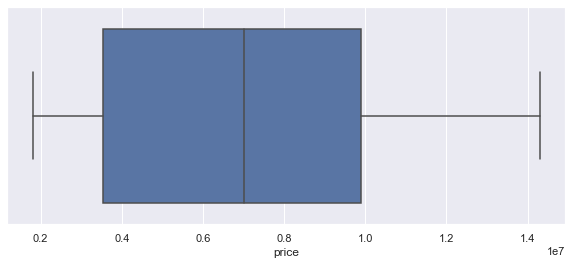

In [260]:
# Построим диаграмму ящик с усами по цене транспортных средств
plt.figure(figsize=(10,4))
sns.boxplot(df_a['price'])

C:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

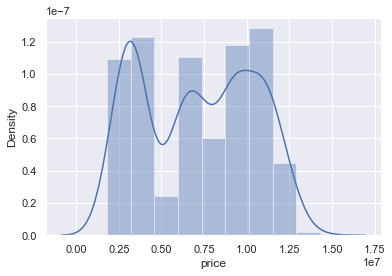

In [261]:
# Построим гистограмму распределения цены
sns.set()
sns.distplot(df_a['price'])

In [262]:
# Описательная статистика для цены
n=df_a['price'].count()
print("Объем выборки: ", n)
print("Минимальное значение: %.3f" % df_a['price'].min())
print("Максимальное значение: %.3f" % df_a['price'].max())
print("Среднее значение: %.3f" % df_a['price'].mean())
print("Медиана: %.3f" % df_a['price'].median())
print("Стандартное отклонение: %.3f" % df_a['price'].std())
print("Вариация: %.3f" % (df_a['price'].std() / df_a['price'].mean()))
print("Эксцесс: %.3f" % df_a['price'].kurt())
E=5*math.sqrt((24*n*(n-1)**2)/((n-3)*(n-2)*(n+3)*(n+5)))
print("Критический эксцесс: %.3f" % E)
print("Асимметрия: %.3f" % df_a['price'].skew())
A=3*math.sqrt((6*n*(n-1))/((n-2)*(n+1)*(n+3)))
print("Критическая асимметрия: %.3f" % A)

Объем выборки:  679
Минимальное значение: 1800000.000
Максимальное значение: 14300000.000
Среднее значение: 7108486.489
Медиана: 7000000.000
Стандартное отклонение: 3274759.519
Вариация: 0.461
Эксцесс: -1.341
Критический эксцесс: 0.937
Асимметрия: -0.015
Критическая асимметрия: 0.281


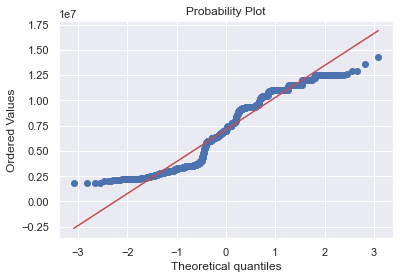

In [263]:
# График Q-Q plot
scipy.stats.probplot(df_a['price'], dist="norm", plot=pylab)
pylab.show()

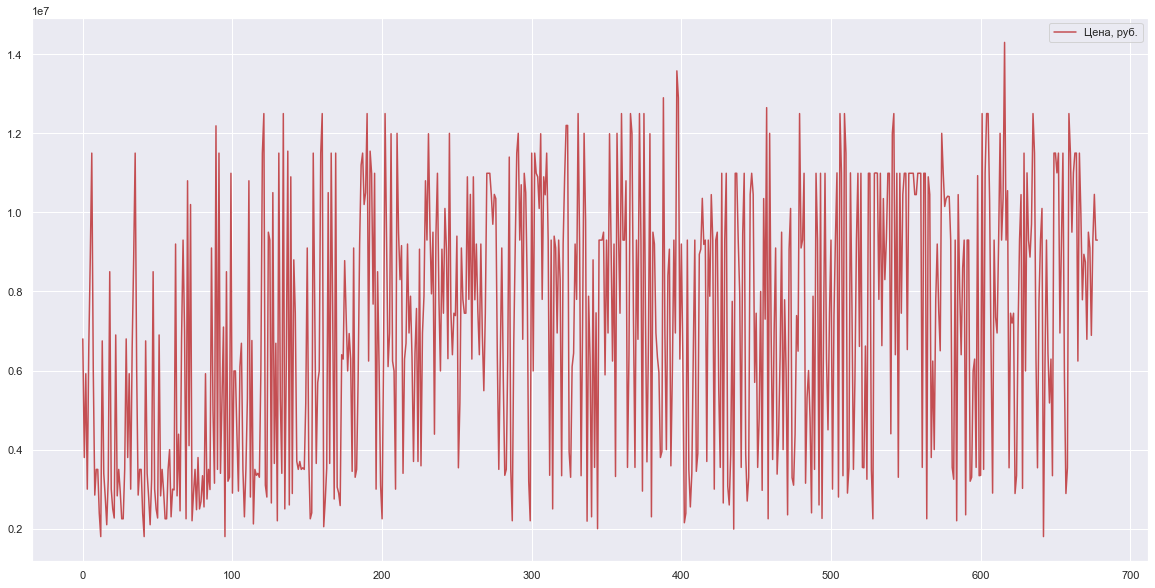

In [264]:
# График цены
x_ax = range(len(df_a['price']))
plt.figure(figsize=(20,10))
plt.plot(x_ax, df_a['price'], c='r', label = "Цена, руб.")
plt.legend()
plt.show()

C:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mileage'>

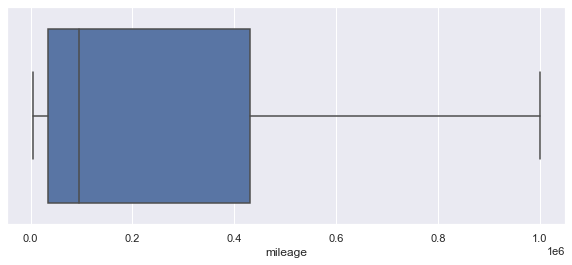

In [265]:
# Построим диаграмму ящик с усами по пробегу транспортных средств и пробегу
plt.figure(figsize=(10,4))
sns.boxplot(df_a['mileage'])

<font size = 3><div style="text-align: justify">**Анализ ценообразующих факторов:**</div></font>

<font size = 3><div style="text-align: justify">**Год выпуска:**</div></font>

In [266]:
df_a['year'].value_counts(sort = True, ascending = False)

2022    244
2020     98
2018     90
2017     79
2019     59
2021     57
2016     35
2015     17
Name: year, dtype: int64

Text(0, 0.5, 'Количество ТС')

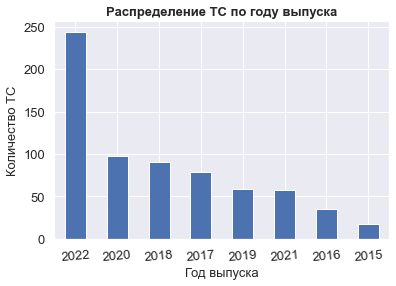

In [267]:
# Столбиковая диаграмма
y = df_a['year'].value_counts(sort = True, ascending = False)
y.plot(kind="bar", rot=5, fontsize=13)
plt.title('Распределение ТС по году выпуска', fontsize=13, fontweight='bold')
plt.xlabel('Год выпуска', fontsize=13)
plt.ylabel('Количество ТС', fontsize=13)

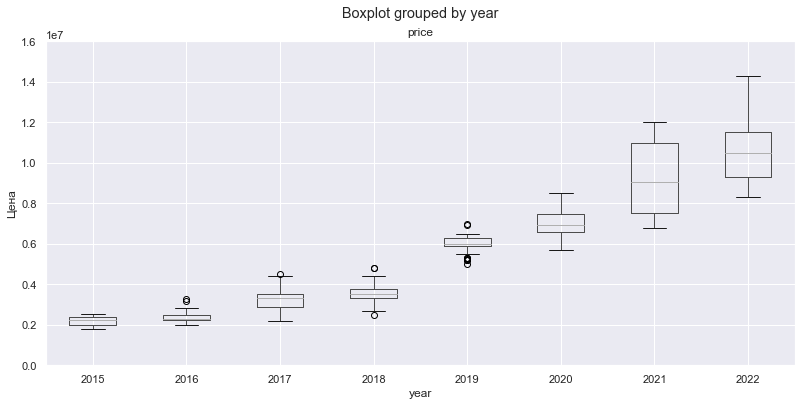

In [268]:
df_year=df_a[['price', 'year']] # берем 2 столбика с данными
fig, ax=plt.subplots(figsize=(13,6))
df_year.boxplot(column='price', by='year', ax=ax)
ax.set_ylim(0,16000000)
plt.ylabel('Цена')
plt.show()

In [269]:
# Статистика Крускала-Уолиса
df_groups=df_a.groupby(by='year')
g_1 = df_groups['price'].get_group(2015)
g_2 = df_groups['price'].get_group(2016)
g_3 = df_groups['price'].get_group(2017)
g_4 = df_groups['price'].get_group(2018)
g_5 = df_groups['price'].get_group(2019)
g_6 = df_groups['price'].get_group(2020)
g_7 = df_groups['price'].get_group(2021)
g_8 = df_groups['price'].get_group(2022)


stat, p=scipy.stats.kruskal(g_1, g_2, g_3, g_4, g_5, g_6, g_7, g_8)
alfa=0.05
print("p-level: ", p)
print("Статистика: ", stat)

if p < alfa:
    print("H0 отклоняется, различие между ценами имеется")
else:
    print("H0 принимается, различия между ценами нет")

print("")
print("Среднее (2015): %.3f" % g_1.median())
print("Среднее (2016): %.3f" % g_2.median())
print("Среднее (2017): %.3f" % g_3.median())
print("Среднее (2018): %.3f" % g_4.median())
print("Среднее (2019): %.3f" % g_5.median())
print("Среднее (2020): %.3f" % g_6.median())
print("Среднее (2021): %.3f" % g_7.median())
print("Среднее (2022): %.3f" % g_8.median())

p-level:  4.665755752187594e-127
Статистика:  607.9755657205192
H0 отклоняется, различие между ценами имеется

Среднее (2015): 2250000.000
Среднее (2016): 2270000.000
Среднее (2017): 3300000.000
Среднее (2018): 3540000.000
Среднее (2019): 5990000.000
Среднее (2020): 6950000.000
Среднее (2021): 9070000.000
Среднее (2022): 10500000.000


<font size = 3><div style="text-align: justify">**Объем двигателя:**</div></font>

In [270]:
df_a['L'].value_counts(sort = True, ascending = False)

11.9    609
6.7      53
11.0     12
8.9       5
Name: L, dtype: int64

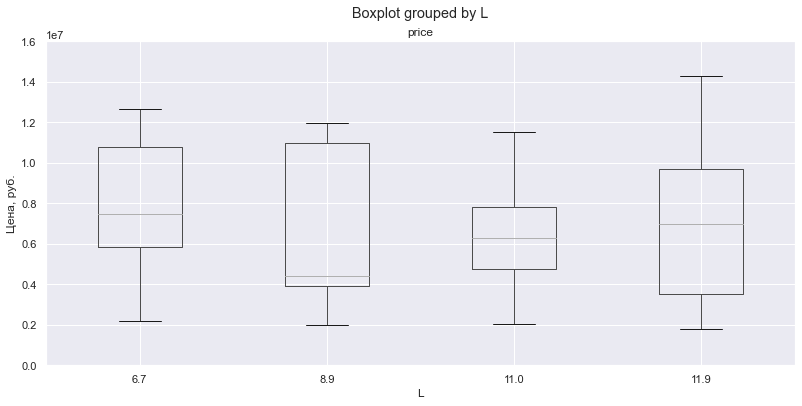

In [271]:
# Рассмотрим зависимость по двигателю
df_eng=df_a[['price', 'L']] # берем 2 столбика с данными
fig, ax=plt.subplots(figsize=(13,6))
df_eng.boxplot(column='price', by='L', ax=ax)
ax.set_ylim(0,16000000)
plt.ylabel('Цена, руб.')
plt.show()

<font size = 3><div style="text-align: justify">**Мощность (л.с.):**</div></font>

In [272]:
df_a['LS'].value_counts(sort = True, ascending = False)

401    387
300    116
450     95
428     50
280     20
292     11
Name: LS, dtype: int64

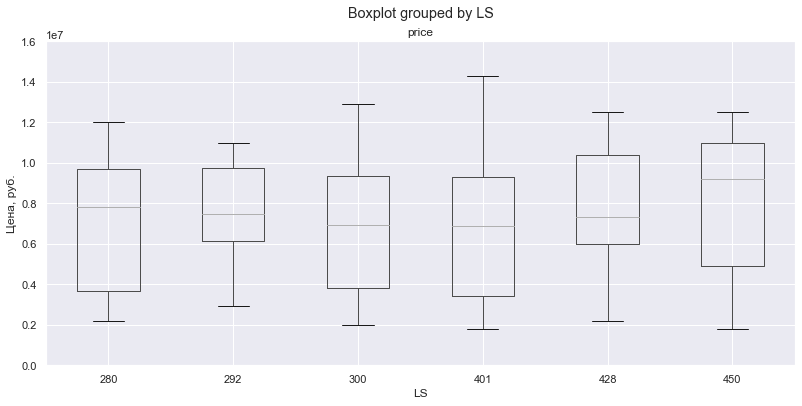

In [273]:
# Рассмотрим зависимость по двигателю
df_eng=df_a[['price', 'LS']] # берем 2 столбика с данными
fig, ax=plt.subplots(figsize=(13,6))
df_eng.boxplot(column='price', by='LS', ax=ax)
ax.set_ylim(0,16000000)
plt.ylabel('Цена, руб.')
plt.show()

<font size = 3><div style="text-align: justify">**Колесная пара:**</div></font>

In [274]:
df_a['KP'].value_counts(sort = True, ascending = False)

 4×2    423
 6×4    125
 6×6    121
 6×2     10
Name: KP, dtype: int64

Text(0, 0.5, 'Количество ТС')

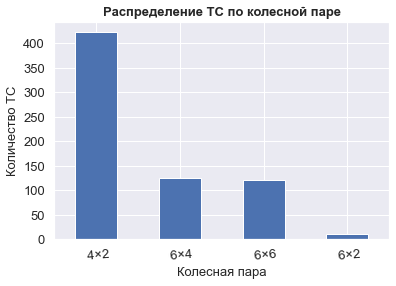

In [275]:
# Столбиковая диаграмма
y = df_a['KP'].value_counts(sort = True, ascending = False)
y.plot(kind="bar", rot=5, fontsize=13)
plt.title('Распределение ТС по колесной паре', fontsize=13, fontweight='bold')
plt.xlabel('Колесная пара', fontsize=13)
plt.ylabel('Количество ТС', fontsize=13)

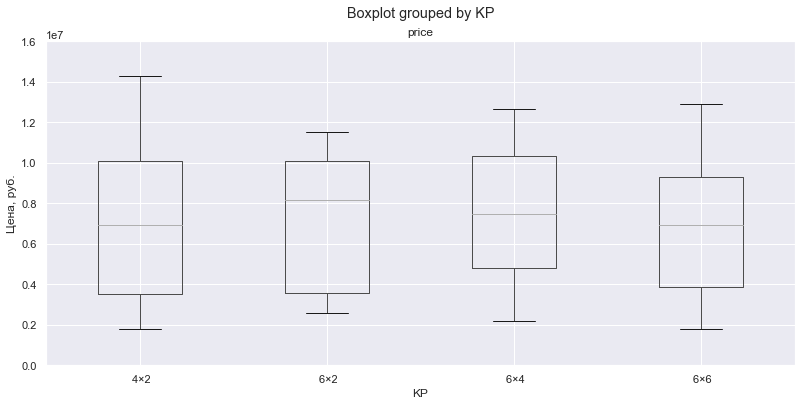

In [276]:
# Рассмотрим зависимость по двигателю
df_eng=df_a[['price', 'KP']] # берем 2 столбика с данными
fig, ax=plt.subplots(figsize=(13,6))
df_eng.boxplot(column='price', by='KP', ax=ax)
ax.set_ylim(0,16000000)
plt.ylabel('Цена, руб.')
plt.show()

<font size = 3><div style="text-align: justify">**Тип топлива:**</div></font>

In [277]:
df_a['fuel'].value_counts(sort = True, ascending = False)

 дизель    676
 газ         3
Name: fuel, dtype: int64

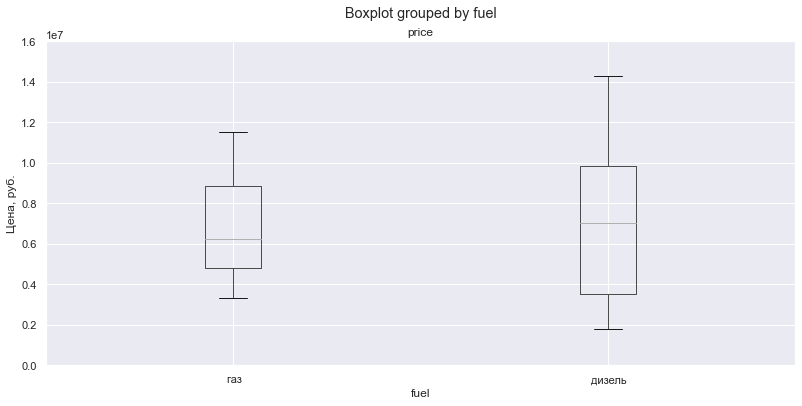

In [278]:
# Рассмотрим зависимость по двигателю
df_eng=df_a[['price', 'fuel']] # берем 2 столбика с данными
fig, ax=plt.subplots(figsize=(13,6))
df_eng.boxplot(column='price', by='fuel', ax=ax)
ax.set_ylim(0,16000000)
plt.ylabel('Цена, руб.')
plt.show()

<font size = 3><div style="text-align: justify">**Класс:**</div></font>

In [279]:
df_a['klass'].value_counts(sort = True, ascending = False)

 Евро 5    650
 Евро 4     25
 Евро 2      4
Name: klass, dtype: int64

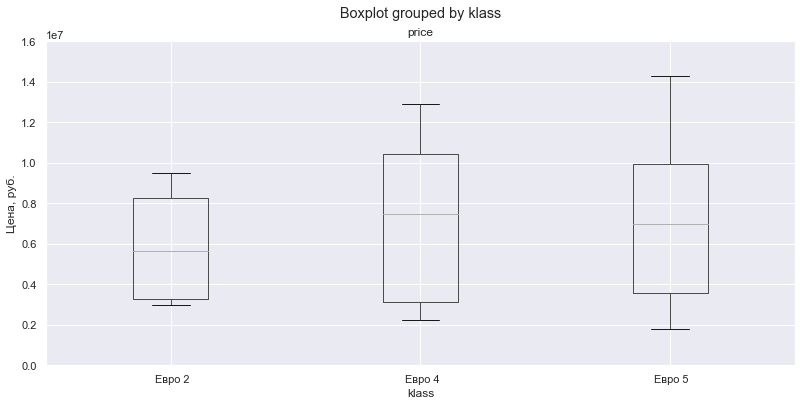

In [280]:
# Рассмотрим зависимость по двигателю
df_eng=df_a[['price', 'klass']] # берем 2 столбика с данными
fig, ax=plt.subplots(figsize=(13,6))
df_eng.boxplot(column='price', by='klass', ax=ax)
ax.set_ylim(0,16000000)
plt.ylabel('Цена, руб.')
plt.show()

<font size = 3><div style="text-align: justify">**Корреляционная матрица:**</div></font>

<AxesSubplot:>

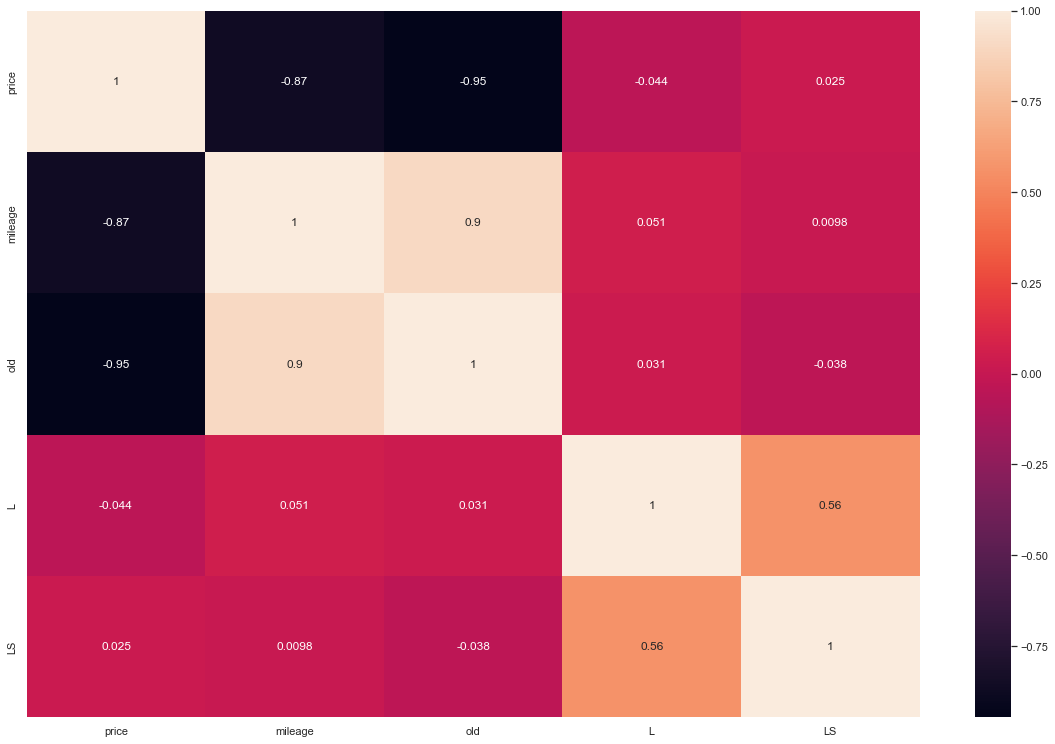

In [281]:
# Строим корреляционную матрицу
numeric_col = ['price', 'mileage','old', 'L', 'LS']
corr_matrix = df_a.loc[:,numeric_col].corr(method="pearson") # pearson, kendall, spearman
#print(corr_matrix)
plt.figure(figsize = (20,13))
sns.heatmap(corr_matrix, annot=True)

<font size = 3><div style="text-align: justify">**Проверка на мультиколлинеарность по методу VIF:**</div></font>

In [282]:
df_a_vif=pd.DataFrame(df_a[['mileage','old', 'L', 'LS']])
Factors = sm.add_constant(df_a_vif) # добавляем константу = 1 к факторам
#Factors

In [283]:
vif = [variance_inflation_factor(exog=Factors.values, 
                                 exog_idx=i) for i in range(Factors.shape[1])]
pd.DataFrame({'Фактор': Factors.columns, 'VIF': np.around(vif, 2)})

,Фактор,VIF
0,const,85.97
1,mileage,5.39
2,old,5.40
3,L,1.46
4,LS,1.48


<font size = 3><div style="text-align: justify">**Преобразование цены:**</div></font>

In [284]:
df_a['ln_price'] = df_a['price'].apply(np.log)
df_a

,brand,model,year,old,price,L,LS,KP,fuel,klass,mileage,ln_price
0,КамАЗ,5490 NEO 2\n,2020,3,6800000,11.9,401,4×2,дизель,Евро 5,87351.0,15.732433
1,КамАЗ,5490 NEO\n,2018,5,3800000,11.9,401,4×2,дизель,Евро 5,330600.0,15.150512
2,КамАЗ,5490,2019,4,5920000,11.9,401,4×2,дизель,Евро 5,255195.0,15.593847
3,КамАЗ,5490 NEO\n,2018,5,3000000,11.9,401,4×2,дизель,Евро 5,430000.0,14.914123
4,КамАЗ,5490-023-87(S5) NEO\n,2020,3,6600000,11.9,401,4×2,дизель,Евро 5,95182.0,15.702580
...,...,...,...,...,...,...,...,...,...,...,...,...
674,КамАЗ,5490-033-87 NEO 2\n,2020,3,6890000,11.9,401,4×2,дизель,Евро 5,241749.0,15.745582
675,КамАЗ,5490-037-87\n,2022,1,9300000,11.9,401,4×2,дизель,Евро 5,33388.5,16.045525
676,КамАЗ,5490 NEO\n,2022,1,10455759,11.9,401,4×2,дизель,Евро 5,33388.5,16.162663
677,КамАЗ,5490-037-87\n,2022,1,9300000,11.9,401,4×2,дизель,Евро 5,33388.5,16.045525


C:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ln_price', ylabel='Density'>

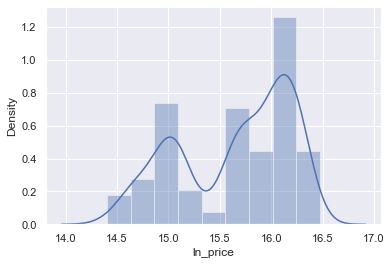

In [285]:
# Построим гистограмму распределения цены
sns.set()
sns.distplot(df_a['ln_price'])

<font size = 4><div style="text-align: justify">**Построение регрессионной модели:**</div></font>

<font size = 3><div style="text-align: justify">**Линейная модель:**</div></font>

In [286]:
# Присваиваем зависимую переменную (цена) Y, а независимые переменные - X
X=df_a['old'] #R2 = 0.891
Y=df_a['price']
# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     4425.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):          1.29e-262
Time:                        08:39:53   Log-Likelihood:                -8313.6
No. Observations:                 543   AIC:                         1.663e+04
Df Residuals:                     541   BIC:                         1.664e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.182e+07   8.26e+04    143.193      0.0

C:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


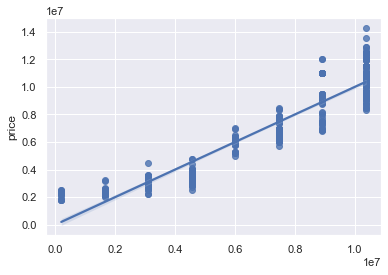

In [287]:
#Обучаем модель и выводим основные данные
X = sm.add_constant(X_train) # добавляем константу = 1 к факторам
#X = X_train

# Строим регрессионную модель
model = sm.OLS(Y_train, X)
results = model.fit()
print(results.summary())

# Строим график
sns.regplot(results.fittedvalues.copy(), Y_train)
plt.show()

In [288]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

model2 = LinearRegression()
model2.fit(X_train.values.reshape(-1, 1), Y_train)

pred_train = model2.predict(X_train.values.reshape(-1, 1))
pred_test = model2.predict(X_test.values.reshape(-1, 1))

Ypred = model2.predict(X_test.values.reshape(-1, 1))

print(f'Train R2: {r2_score(Y_train, pred_train):.3f}')
print(f'MAE на обучении: {mae(Y_train, pred_train):.0f}')

print(f'Test R2: {r2_score(Y_test, pred_test):.3f}')
print(f'MAE на тесте: {mae(Y_test, pred_test):.0f}')

Train R2: 0.891
MAE на обучении: 867721
Test R2: 0.908
MAE на тесте: 780886


In [289]:
# кросс-валидация
from sklearn.model_selection import cross_val_score

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#model2 = LinearRegression()

cv_results = cross_val_score(model2, X_train.values.reshape(-1, 1), Y_train, cv=5)
cv_results

array([0.87221112, 0.8843179 , 0.88470581, 0.89667472, 0.91164189])

In [290]:
# среднее значение качества модели
cv_results.mean()

0.8899102905196761

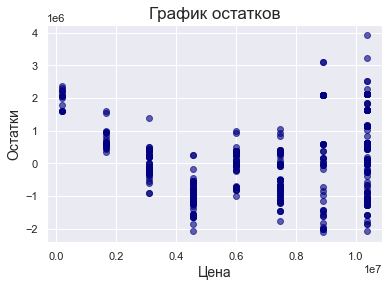

In [291]:
# Строим график остатков обучающей выборки
plt.scatter(x=results.fittedvalues, y=results.resid, c='navy', alpha=0.6)
plt.xlabel('Цена', fontsize=14)
plt.ylabel('Остатки', fontsize=14)
plt.title('График остатков', fontsize=17)
plt.show()

C:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


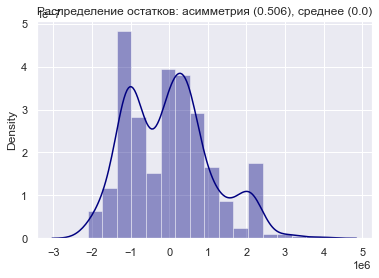

In [292]:
# Строим гистограмму распределения остатков обучающей выборки
resid_mean=round(results.resid.mean(), 3)
resid_skew=round(results.resid.skew(), 3)
coef=pd.DataFrame({'Коэфф': results.params})
sns.distplot(results.resid, color='navy')
plt.title(f'Распределение остатков: асимметрия ({resid_skew}), среднее ({resid_mean})', fontsize=12)
plt.show()

In [293]:
coef=pd.DataFrame({'Коэфф': results.params})
coef

,Коэфф
const,1.182124e+07
old,-1.452722e+06


<font size = 2><div style="text-align: justify">**Цена = (11821240 - 1452722 х old) х Торг**</div></font>

Остатки распределены ненормально.

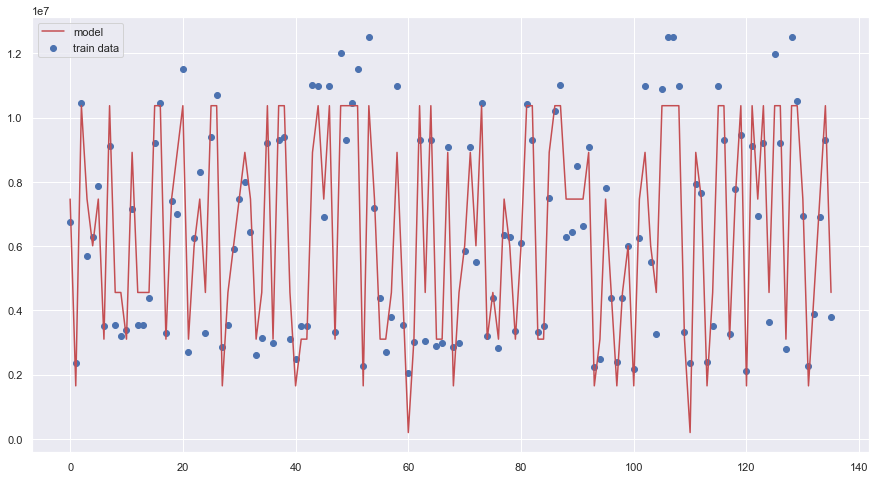

In [294]:
plt.figure(figsize=(15, 8))
plt.plot(range(len(Y_test)), Ypred, c='r', label='model');
plt.scatter(range(len(Y_test)), Y_test, label='train data')
plt.legend();

<font size = 3><div style="text-align: justify">**Нелинейная модель (экспанента):**</div></font>

In [295]:
# Присваиваем зависимую переменную (цена) Y, а независимые переменные - X
X=df_a['old'] #R2 = 0.932
Y=df_a['ln_price']
# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     7413.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):          5.97e-318
Time:                        08:40:48   Log-Likelihood:                 293.56
No. Observations:                 543   AIC:                            -583.1
Df Residuals:                     541   BIC:                            -574.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.4403      0.011   1524.774      0.0

C:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


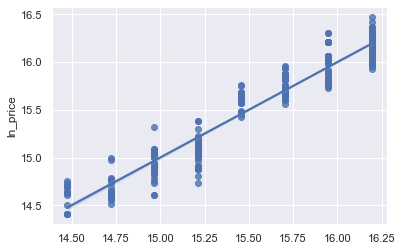

In [296]:
#Обучаем модель и выводим основные данные
X = sm.add_constant(X_train) # добавляем константу = 1 к факторам
#X = X_train

# Строим регрессионную модель
model = sm.OLS(Y_train, X)
results = model.fit()
print(results.summary())

# Строим график
sns.regplot(results.fittedvalues.copy(), Y_train)
plt.show()

In [297]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

model2 = LinearRegression()
model2.fit(X_train.values.reshape(-1, 1), Y_train)

pred_train = model2.predict(X_train.values.reshape(-1, 1))
pred_test = model2.predict(X_test.values.reshape(-1, 1))

Ypred = model2.predict(X_test.values.reshape(-1, 1))

print(f'Train R2: {r2_score(Y_train, pred_train):.3f}')
print(f'MAE на обучении: {mae(Y_train, pred_train):.5f}')

print(f'Test R2: {r2_score(Y_test, pred_test):.3f}')
print(f'MAE на тесте: {mae(Y_test, pred_test):.5f}')

Train R2: 0.932
MAE на обучении: 0.11644
Test R2: 0.941
MAE на тесте: 0.11249


In [298]:
# кросс-валидация
from sklearn.model_selection import cross_val_score

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#model2 = LinearRegression()

cv_results = cross_val_score(model2, X_train.values.reshape(-1, 1), Y_train, cv=5)
cv_results

array([0.93228419, 0.91948249, 0.93760323, 0.92822814, 0.93949438])

In [299]:
# среднее значение качества модели
cv_results.mean()

0.9314184871351159

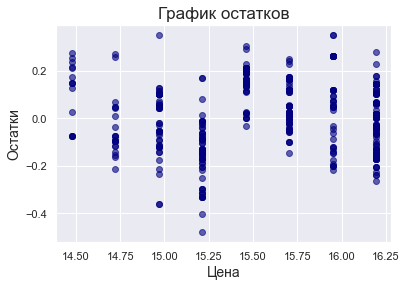

In [300]:
# Строим график остатков обучающей выборки
plt.scatter(x=results.fittedvalues, y=results.resid, c='navy', alpha=0.6)
plt.xlabel('Цена', fontsize=14)
plt.ylabel('Остатки', fontsize=14)
plt.title('График остатков', fontsize=17)
plt.show()

C:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


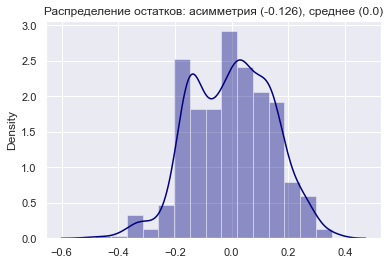

In [301]:
# Строим гистограмму распределения остатков обучающей выборки
resid_mean=round(results.resid.mean(), 3)
resid_skew=round(results.resid.skew(), 3)
coef=pd.DataFrame({'Коэфф': results.params})
sns.distplot(results.resid, color='navy')
plt.title(f'Распределение остатков: асимметрия ({resid_skew}), среднее ({resid_mean})', fontsize=12)
plt.show()

In [302]:
coef=pd.DataFrame({'Коэфф': results.params})
coef

,Коэфф
const,16.440272
old,-0.245562


<font size = 2><div style="text-align: justify">**Цена = exp(16.440272 - 0.245562 х old) х Торг**</div></font>

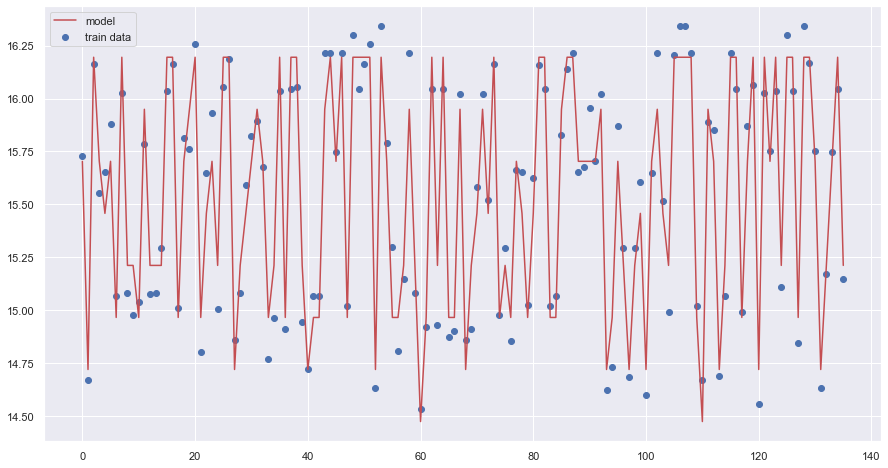

In [303]:
plt.figure(figsize=(15, 8))
plt.plot(range(len(Y_test)), Ypred, c='r', label='model');
plt.scatter(range(len(Y_test)), Y_test, label='train data')
plt.legend();

<font size = 3><div style="text-align: justify">**Нелинейная модель (степенная):**</div></font>

In [304]:
df_a['ln_old'] = df_a['old'].apply(np.log)
df_a

,brand,model,year,old,price,L,LS,KP,fuel,klass,mileage,ln_price,ln_old
0,КамАЗ,5490 NEO 2\n,2020,3,6800000,11.9,401,4×2,дизель,Евро 5,87351.0,15.732433,1.098612
1,КамАЗ,5490 NEO\n,2018,5,3800000,11.9,401,4×2,дизель,Евро 5,330600.0,15.150512,1.609438
2,КамАЗ,5490,2019,4,5920000,11.9,401,4×2,дизель,Евро 5,255195.0,15.593847,1.386294
3,КамАЗ,5490 NEO\n,2018,5,3000000,11.9,401,4×2,дизель,Евро 5,430000.0,14.914123,1.609438
4,КамАЗ,5490-023-87(S5) NEO\n,2020,3,6600000,11.9,401,4×2,дизель,Евро 5,95182.0,15.702580,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,КамАЗ,5490-033-87 NEO 2\n,2020,3,6890000,11.9,401,4×2,дизель,Евро 5,241749.0,15.745582,1.098612
675,КамАЗ,5490-037-87\n,2022,1,9300000,11.9,401,4×2,дизель,Евро 5,33388.5,16.045525,0.000000
676,КамАЗ,5490 NEO\n,2022,1,10455759,11.9,401,4×2,дизель,Евро 5,33388.5,16.162663,0.000000
677,КамАЗ,5490-037-87\n,2022,1,9300000,11.9,401,4×2,дизель,Евро 5,33388.5,16.045525,0.000000


In [305]:
# Присваиваем зависимую переменную (цена) Y, а независимые переменные - X
X=df_a['ln_old'] #R2 = 0.848
Y=df_a['ln_price']
# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     3023.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):          1.24e-223
Time:                        08:41:49   Log-Likelihood:                 75.631
No. Observations:                 543   AIC:                            -147.3
Df Residuals:                     541   BIC:                            -138.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.2489      0.014   1173.162      0.0

C:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


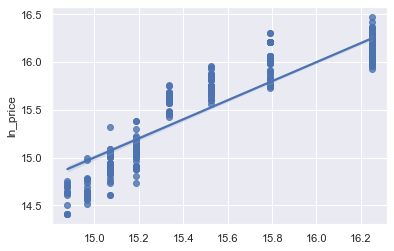

In [306]:
#Обучаем модель и выводим основные данные
X = sm.add_constant(X_train) # добавляем константу = 1 к факторам
#X = X_train

# Строим регрессионную модель
model = sm.OLS(Y_train, X)
results = model.fit()
print(results.summary())

# Строим график
sns.regplot(results.fittedvalues.copy(), Y_train)
plt.show()

R2 = 0.83, ниже, чем у экспоненциальной модели. Остатки распределены ненормально.

<font size = 3><div style="text-align: justify">**Нелинейная модель (гипербола):**</div></font>

In [307]:
df_a['old_g'] = 1/df_a['old']
df_a

,brand,model,year,old,price,L,LS,KP,fuel,klass,mileage,ln_price,ln_old,old_g
0,КамАЗ,5490 NEO 2\n,2020,3,6800000,11.9,401,4×2,дизель,Евро 5,87351.0,15.732433,1.098612,0.333333
1,КамАЗ,5490 NEO\n,2018,5,3800000,11.9,401,4×2,дизель,Евро 5,330600.0,15.150512,1.609438,0.200000
2,КамАЗ,5490,2019,4,5920000,11.9,401,4×2,дизель,Евро 5,255195.0,15.593847,1.386294,0.250000
3,КамАЗ,5490 NEO\n,2018,5,3000000,11.9,401,4×2,дизель,Евро 5,430000.0,14.914123,1.609438,0.200000
4,КамАЗ,5490-023-87(S5) NEO\n,2020,3,6600000,11.9,401,4×2,дизель,Евро 5,95182.0,15.702580,1.098612,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,КамАЗ,5490-033-87 NEO 2\n,2020,3,6890000,11.9,401,4×2,дизель,Евро 5,241749.0,15.745582,1.098612,0.333333
675,КамАЗ,5490-037-87\n,2022,1,9300000,11.9,401,4×2,дизель,Евро 5,33388.5,16.045525,0.000000,1.000000
676,КамАЗ,5490 NEO\n,2022,1,10455759,11.9,401,4×2,дизель,Евро 5,33388.5,16.162663,0.000000,1.000000
677,КамАЗ,5490-037-87\n,2022,1,9300000,11.9,401,4×2,дизель,Евро 5,33388.5,16.045525,0.000000,1.000000


In [308]:
# Присваиваем зависимую переменную (цена) Y, а независимые переменные - X
X=df_a['old_g']
Y=df_a['price']
# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     2101.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):          1.98e-188
Time:                        08:57:49   Log-Likelihood:                -8485.0
No. Observations:                 543   AIC:                         1.697e+04
Df Residuals:                     541   BIC:                         1.698e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.959e+06   1.14e+05     26.024      0.0

C:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


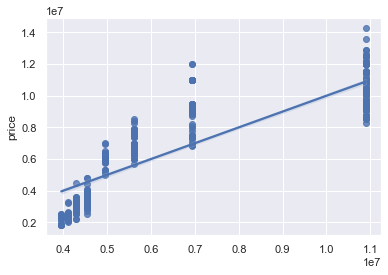

In [309]:
#Обучаем модель и выводим основные данные
X = sm.add_constant(X_train) # добавляем константу = 1 к факторам
#X = X_train

# Строим регрессионную модель
model = sm.OLS(Y_train, X)
results = model.fit()
print(results.summary())

# Строим график
sns.regplot(results.fittedvalues.copy(), Y_train)
plt.show()

R2 = 0.795, ниже, чем у экспоненциальной модели. Остатки распределены ненормально.

<font size = 3><div style="text-align: justify">**Вывод:**</div></font>

Наилучшей моделью является нелинейная экспоненциальная модель (R2 = 0,93), остатки распределены нормально, мультиколлинеарность и гетероскедастичность не наблюдаются.

<font size = 2><div style="text-align: justify">**Цена = exp(16.440272 - 0.245562 х old) х Торг**</div></font>